In [1]:
import numpy as np 
import pandas as pd
#import calendar
import math

# plots
import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline

In [2]:
filenames = ['properties/properati-AR-2016-03-01-properties-sell-six_months.csv',
            'properties/properati-AR-2016-04-01-properties-sell.csv',
            'properties/properati-AR-2016-05-01-properties-sell.csv',
            'properties/properati-AR-2016-06-01-properties-sell.csv',
            'properties/properati-AR-2016-07-01-properties-sell.csv',
            'properties/properati-AR-2016-08-01-properties-sell.csv',
            'properties/properati-AR-2016-09-01-properties-sell.csv',
            'properties/properati-AR-2016-10-01-properties-sell.csv',
            'properties/properati-AR-2016-11-01-properties-sell.csv',
            'properties/properati-AR-2016-12-01-properties-sell.csv', 
            'properties/properati-AR-2017-01-01-properties-sell.csv',
            'properties/properati-AR-2017-02-01-properties-sell.csv',
            'properties/properati-AR-2017-08-01-properties-sell-six_months.csv']

dataframes = []
for filename in filenames:
    dataframes.append(pd.read_csv(filename))

# SAQUE ESTO PARA HACER LA REGRESION A PARTIR DEL 2DO SEMESTRE DEL 2016
#dataframes.append(pd.read_csv('properties/properati-AR-2015-07-01-properties-sell.csv', skiprows=[81550]))
#dataframes.append(pd.read_csv('properties/properati-AR-2015-08-01-properties-sell.csv', skiprows=[75032]))
#dataframes.append(pd.read_csv('properties/properati-AR-2015-09-01-properties-sell.csv', skiprows=[54374]))
#dataframes.append(pd.read_csv('properties/properati-AR-2015-12-01-properties-sell.csv', skiprows=[101832]))
#Uno los dataframe
metadata = pd.DataFrame()
for dataframe in dataframes:
    metadata = pd.concat([metadata, dataframe]).drop_duplicates().reset_index(drop=True)

In [3]:
data = metadata.loc[(metadata.state_name.str.contains('Buenos Aires')) | (metadata.state_name.str.contains\
                ('Capital Federal'))  | (metadata.state_name.str.contains\
                ('Bs.As') ),:]
data.shape
# 1.283.741 entries antes, ahora 242290

(242290, 27)

In [4]:
test = pd.read_csv('properties/properati_dataset_testing_noprice.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14166 entries, 0 to 14165
Data columns (total 17 columns):
id                         14166 non-null int64
created_on                 14166 non-null object
property_type              14166 non-null object
operation                  14166 non-null object
place_name                 14166 non-null object
place_with_parent_names    14166 non-null object
country_name               14166 non-null object
state_name                 14166 non-null object
lat-lon                    10487 non-null object
lat                        10487 non-null float64
lon                        10487 non-null float64
surface_total_in_m2        11853 non-null float64
surface_covered_in_m2      13005 non-null float64
floor                      1368 non-null float64
rooms                      7500 non-null float64
expenses                   2543 non-null object
description                14166 non-null object
dtypes: float64(6), int64(1), object(10)
memory usage: 1

In [5]:
test_visualiz = test.loc[:,['state_name', 'id']].groupby('state_name').agg(np.size)
test_visualiz.head(10)

,id
state_name,
Bs.As. G.B.A. Zona Norte,2
Bs.As. G.B.A. Zona Oeste,3101
Bs.As. G.B.A. Zona Sur,2215
Buenos Aires Interior,1
Capital Federal,8847


In [6]:
# Depuración del set de test
#Completo los valores NaN con promedios para realizar la predicción
prom_surface_total_in_m2 = test['surface_total_in_m2'].mean()
prom_surface_covered_in_m2 = test['surface_covered_in_m2'].mean()
prom_rooms = int(test['rooms'].mean())
prom_lat = test['lat'].mean()
prom_lon = test['lon'].mean()

test_float = test
test_float['surface_total_in_m2'].fillna(prom_surface_total_in_m2, inplace=True)
test_float['surface_covered_in_m2'].fillna(prom_surface_covered_in_m2, inplace=True)
test_float['rooms'].fillna(prom_rooms, inplace=True)
test_float['lat'].fillna(prom_lat, inplace=True)
test_float['lon'].fillna(prom_lon, inplace=True)


test_float.head(100)

,id,created_on,property_type,operation,place_name,place_with_parent_names,country_name,state_name,lat-lon,lat,lon,surface_total_in_m2,surface_covered_in_m2,floor,rooms,expenses,description
0,3632,2017-08-24,departamento,venta,Puerto Madero,|Argentina|Capital Federal|Puerto Madero|,Argentina,Capital Federal,"-34.6109877599,-58.3634635778",-34.610988,-58.363464,0.000000,359.471588,NaN,2.0,NaN,Edificio BA Houses situado frente al Dique 3 d...
1,3633,2017-08-25,departamento,venta,Buenos Aires Interior,|Argentina|Buenos Aires Interior|,Argentina,Buenos Aires Interior,NaN,-34.629923,-58.465820,0.000000,359.471588,NaN,2.0,NaN,El departamento cuenta con un living-comedor a...
2,2263404,2017-08-01,departamento,venta,Palermo Soho,|Argentina|Capital Federal|Palermo|Palermo Soho|,Argentina,Capital Federal,"-34.5893633232,-58.4128798588",-34.589363,-58.412880,53.000000,48.000000,NaN,2.0,1500,IMPECABLE TORRE COY III – DEPA...
3,2263405,2017-08-01,departamento,venta,Chacarita,|Argentina|Capital Federal|Chacarita|,Argentina,Capital Federal,NaN,-34.629923,-58.465820,39.000000,39.000000,NaN,2.0,NaN,AMBIENTE DIVISIBLE CON PISOS D...
4,2263406,2017-08-01,departamento,venta,Chacarita,|Argentina|Capital Federal|Chacarita|,Argentina,Capital Federal,NaN,-34.629923,-58.465820,51.000000,51.000000,NaN,2.0,NaN,LIVING COMEDOR CON PISOS DE PO...
5,2263407,2017-08-01,departamento,venta,Chacarita,|Argentina|Capital Federal|Chacarita|,Argentina,Capital Federal,NaN,-34.629923,-58.465820,39.000000,39.000000,NaN,2.0,NaN,AMBIENTE DIVISIBLE CON PISOS D...
6,2263408,2017-08-01,departamento,venta,Chacarita,|Argentina|Capital Federal|Chacarita|,Argentina,Capital Federal,NaN,-34.629923,-58.465820,39.000000,39.000000,NaN,2.0,NaN,AMBIENTE DIVISIBLE CON PISOS D...
7,2263409,2017-08-01,departamento,venta,Chacarita,|Argentina|Capital Federal|Chacarita|,Argentina,Capital Federal,NaN,-34.629923,-58.465820,39.000000,39.000000,NaN,2.0,NaN,AMBIENTE DIVISIBLE CON PISOS D...
8,2263410,2017-08-01,departamento,venta,Colegiales,|Argentina|Capital Federal|Colegiales|,Argentina,Capital Federal,"-34.5787213694,-58.4570952614",-34.578721,-58.457095,67.000000,67.000000,NaN,2.0,2600,EXCELENTE 2 AMB- APTO PROFESIO...
9,2263411,2017-08-01,departamento,venta,Almagro,|Argentina|Capital Federal|Almagro|,Argentina,Capital Federal,NaN,-34.629923,-58.465820,47.000000,47.000000,NaN,2.0,NaN,IMPECABLE MONOAMBIENTE- DIVISI...


In [7]:
test_float.count()

id                         14166
created_on                 14166
property_type              14166
operation                  14166
place_name                 14166
place_with_parent_names    14166
country_name               14166
state_name                 14166
lat-lon                    10487
lat                        14166
lon                        14166
surface_total_in_m2        14166
surface_covered_in_m2      14166
floor                       1368
rooms                      14166
expenses                    2543
description                14166
dtype: int64

<br><B><FONT FACE="Arial" SIZE="5">Preparo los datos</FONT></B><br/>

In [8]:
#FILTRO LOS DATOS ANOMALOS

data_float = data.loc[:, ['price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2',\
                          'rooms', 'lat', 'lon']].dropna()

#filtro de KNN (más exhaustivo)
data_float = \
data_float.loc[((data_float.surface_total_in_m2 >= 10.0) & (data_float.surface_total_in_m2 <= 1000.0)) & \
               ((data_float.surface_covered_in_m2 >= 15.0) & (data_float.surface_covered_in_m2 <= 800.0)) & \
#               ((data_float.floor >= 1.0) & (data_float.floor <= 6.0)) & \
               ((data_float.rooms >= 1.0) & (data_float.rooms <= 12.0)), :]

data_float.shape
#(63773, 6)

(63773, 6)

## Uso PCA como reductor de dimensiones para sumar dos nuevas dimensiones al dataset

In [9]:
data_float_pca = data_float.loc[:,['surface_total_in_m2', 'surface_covered_in_m2',\
                          'rooms', 'lat', 'lon']]
data_float_pca

,surface_total_in_m2,surface_covered_in_m2,rooms,lat,lon
0,500.0,500.0,6.0,-34.643701,-58.651548
13,135.0,135.0,4.0,-34.546433,-58.545713
14,330.0,310.0,6.0,-34.345731,-58.855461
16,30.0,30.0,2.0,-34.649843,-58.657190
17,47.0,47.0,2.0,-34.651906,-58.644602
19,294.0,100.0,4.0,-34.767167,-58.215465
20,79.0,70.0,3.0,-34.578408,-58.495869
21,75.0,65.0,2.0,-34.401696,-58.640455
23,47.0,34.0,1.0,-34.570822,-58.448714
24,354.0,354.0,5.0,-34.497833,-58.483518


In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(data_float_pca)
red = pca.transform(data_float_pca)
print(pca.singular_values_)

[ 39093.05050765  12073.21127604]


In [11]:
red

array([[ 511.51616956,  211.29500248],
       [  26.32508928,   35.12523075],
       [ 277.07651325,  111.13657304],
       ..., 
       [-117.24994311,  -17.04397129],
       [  36.47689064,   23.760976  ],
       [ 257.35255825,  -72.83368091]])

In [12]:
d = {'col1': red[:,0], 'col2': red[:,1]}
red_data = pd.DataFrame(data=d)

data_float.reset_index(inplace=True)
data_float['PCA1'] = red_data['col1']
data_float['PCA2'] = red_data['col2']
data_float.tail()

,index,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,rooms,lat,lon,PCA1,PCA2
63768,295459,50000.0,70.0,200.0,3.0,-38.030114,-57.574442,-5.053965,121.497399
63769,295460,74000.0,39.0,39.0,2.0,-38.002849,-57.544908,-101.292954,-11.242061
63770,295461,45000.0,27.0,27.0,1.0,-37.996638,-57.550819,-117.249943,-17.043971
63771,295462,349000.0,149.0,129.0,5.0,-37.099113,-56.840540,36.476891,23.760976
63772,295463,75000.0,390.0,135.0,4.0,-37.837561,-58.259803,257.352558,-72.833681


In [13]:
test_float_pca = test_float.loc[:, ['surface_total_in_m2', 'surface_covered_in_m2',\
                                    'rooms', 'lat', 'lon']]
test_float_pca

,surface_total_in_m2,surface_covered_in_m2,rooms,lat,lon
0,0.0,359.471588,2.0,-34.610988,-58.363464
1,0.0,359.471588,2.0,-34.629923,-58.465820
2,53.0,48.000000,2.0,-34.589363,-58.412880
3,39.0,39.000000,2.0,-34.629923,-58.465820
4,51.0,51.000000,2.0,-34.629923,-58.465820
5,39.0,39.000000,2.0,-34.629923,-58.465820
6,39.0,39.000000,2.0,-34.629923,-58.465820
7,39.0,39.000000,2.0,-34.629923,-58.465820
8,67.0,67.000000,2.0,-34.578721,-58.457095
9,47.0,47.000000,2.0,-34.629923,-58.465820


In [14]:
red_test = pca.transform(test_float_pca)
red_test

array([[  -0.98025107,  295.60106475],
       [  -0.9802364 ,  295.60110693],
       [ -84.80221248,   -8.99928294],
       ..., 
       [ 102.41584434,   -0.45547254],
       [ -76.64840526,  -12.80890596],
       [ 234.39633301,  -67.61311247]])

In [15]:
d = {'col1': red_test[:,0], 'col2': red_test[:,1]}
red_test_data = pd.DataFrame(data=d)

#test_float.reset_index(inplace=True)
test_float['PCA1'] = red_test_data['col1']
test_float['PCA2'] = red_test_data['col2']
test_float.tail()

,id,created_on,property_type,operation,place_name,place_with_parent_names,country_name,state_name,lat-lon,lat,lon,surface_total_in_m2,surface_covered_in_m2,floor,rooms,expenses,description,PCA1,PCA2
14161,2245938,2017-08-01,departamento,venta,Puerto Madero,|Argentina|Capital Federal|Puerto Madero|,Argentina,Capital Federal,"-34.6115752,-58.3630313",-34.611575,-58.363031,109.0,96.0,NaN,2.0,8500,"Edificio.""Terrazas del Dique"".Al Frente.Balcón...",-13.749959,10.778815
14162,2245978,2017-08-17,ph,venta,Temperley,|Argentina|Bs.As. G.B.A. Zona Sur|Lomas de Zam...,Argentina,Bs.As. G.B.A. Zona Sur,"-34.7821307,-58.4157403",-34.782131,-58.415740,38.0,26.0,NaN,2.0,NaN,Venta de imperdible PH con patio 2 AMBIENTE...,-107.703887,-22.580467
14163,2246083,2017-08-01,casa,venta,Lomas de Zamora,|Argentina|Bs.As. G.B.A. Zona Sur|Lomas de Zam...,Argentina,Bs.As. G.B.A. Zona Sur,"-34.7585252,-58.4097202",-34.758525,-58.409720,219.0,135.0,NaN,2.0,NaN,"Venta de Casa 4 AMBIENTES en Lomas de Zamora, ...",102.415844,-0.455473
14164,2246089,2017-08-25,departamento,venta,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,"-34.563221078,-58.4610526805",-34.563221,-58.461053,62.0,48.0,NaN,2.0,4128,DEPARTAMENTO EN VENTA / ALQUILER | BELGRANO ...,-76.648405,-12.808906
14165,2246127,2017-08-12,casa,venta,Ciudad Evita,|Argentina|Bs.As. G.B.A. Zona Oeste|La Matanza...,Argentina,Bs.As. G.B.A. Zona Oeste,"-34.7091916902,-58.5302893817",-34.709192,-58.530289,367.0,130.0,NaN,4.0,NaN,Venta de Chalet 4 AMBIENTES en CIRCUNSCRIPCIÓN...,234.396333,-67.613112


<br><B><FONT FACE="Arial" SIZE="5">Prediccion usando regresion lineal, en base a las propiedades: 'surface_total_in_m2', 'surface_covered_in_m2', 'rooms', 'PCA1', 'PCA2'</FONT></B><br/>

In [16]:
data_float.describe()

,index,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,rooms,lat,lon,PCA1,PCA2
count,63773.000000,6.377300e+04,63773.000000,63773.000000,63773.000000,63773.000000,63773.000000,6.377300e+04,6.377300e+04
mean,128466.533862,2.057773e+05,126.018017,92.046038,2.879683,-35.171729,-58.364095,-6.311667e-14,-2.733962e-15
std,73612.140164,2.726486e+05,141.702830,78.545358,1.410860,1.738054,1.186511,1.548048e+02,4.780879e+01
min,0.000000,0.000000e+00,10.000000,15.000000,1.000000,-41.167596,-122.419415,-1.338114e+02,-3.902453e+02
25%,63439.000000,8.500000e+04,47.000000,42.000000,2.000000,-34.673950,-58.515934,-9.236035e+01,-1.401869e+01
50%,133100.000000,1.320000e+05,74.000000,65.000000,3.000000,-34.607218,-58.434713,-5.911125e+01,-5.933452e+00
75%,189221.000000,2.300000e+05,143.000000,110.000000,4.000000,-34.571150,-58.377844,2.631583e+01,1.002141e+01
max,295463.000000,8.500000e+06,1000.000000,800.000000,12.000000,37.774929,3.379206,1.091496e+03,6.185035e+02


In [17]:
# actualmente trabajamos con 4602 entries
data_float.shape
#(63773, 9)

(63773, 9)

In [18]:
# proceso de normalización de los datos. Por ahora no lo estamos usando, no nos mejoró nada
import pandas as pd
from sklearn import preprocessing

data_float_reduced = data_float.loc[:, ['surface_total_in_m2', 'surface_covered_in_m2', 'floor', 'rooms',\
                      'lat', 'lon']]
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(data_float_reduced)
data_float_norm = pd.DataFrame(np_scaled)
data_float_norm.columns=['surface_total_in_m2', 'surface_covered_in_m2', 'floor', 'rooms',\
                      'lat', 'lon']
data_float_norm.describe()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [19]:
# para evitar la normalización meter esos hashtags acá
#data_float = data_float_norm
#data_float.describe()

In [20]:
#Creo X e Y
feature_cols = ['surface_total_in_m2', 'surface_covered_in_m2', 'rooms', 'PCA1', 'PCA2']
X = data_float[feature_cols]
y = data_float.price_aprox_usd

from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X, y)

# Printeo los coeficientes
print (lm.intercept_)
print (lm.coef_)

-16072078678.2
[  8.74647284e+07   5.48425197e+07   7.34858896e+05  -1.02458496e+08
  -1.26631364e+07]


In [21]:
# Uno los coeficientes con su respectiva columna
zip(feature_cols, lm.coef_)

[('surface_total_in_m2', 87464728.361165062),
 ('surface_covered_in_m2', 54842519.685583465),
 ('rooms', 734858.89634674997),
 ('PCA1', -102458496.08961774),
 ('PCA2', -12663136.359968545)]

In [22]:
test.shape

(14166, 19)

In [23]:
test_float['price_aprox_usd_LR'] = lm.predict(test_float.loc[:, ['surface_total_in_m2', 'surface_covered_in_m2',\
                                'rooms', 'PCA1', 'PCA2']])
test_float.head()
#PREGUNTAS
#HAY QUE FILTRAR EL .CSV QUE TENEMOS QUE PREDECIR? HAY DATOS TRUCHOS. ésta es una pregunta realmente importante
#USANDO REGRESION, HAGO LA PREDDCION DE LAS PROPIEDADES QUE SOLAMENTE TIENEN LAS 4 COLUMNAS CON DATOS POR LAS QUE HAGO
#LA PREDICCION?

,id,created_on,property_type,operation,place_name,place_with_parent_names,country_name,state_name,lat-lon,lat,lon,surface_total_in_m2,surface_covered_in_m2,floor,rooms,expenses,description,PCA1,PCA2,price_aprox_usd_LR
0,3632,2017-08-24,departamento,venta,Puerto Madero,|Argentina|Capital Federal|Puerto Madero|,Argentina,Capital Federal,"-34.6109877599,-58.3634635778",-34.610988,-58.363464,0.0,359.471588,NaN,2.0,NaN,Edificio BA Houses situado frente al Dique 3 d...,-0.980251,295.601065,917132.216133
1,3633,2017-08-25,departamento,venta,Buenos Aires Interior,|Argentina|Buenos Aires Interior|,Argentina,Buenos Aires Interior,NaN,-34.629923,-58.465820,0.0,359.471588,NaN,2.0,NaN,El departamento cuenta con un living-comedor a...,-0.980236,295.601107,915094.903572
2,2263404,2017-08-01,departamento,venta,Palermo Soho,|Argentina|Capital Federal|Palermo|Palermo Soho|,Argentina,Capital Federal,"-34.5893633232,-58.4128798588",-34.589363,-58.412880,53.0,48.000000,NaN,2.0,1500,IMPECABLE TORRE COY III – DEPA...,-84.802212,-8.999283,128890.894117
3,2263405,2017-08-01,departamento,venta,Chacarita,|Argentina|Capital Federal|Chacarita|,Argentina,Capital Federal,NaN,-34.629923,-58.465820,39.0,39.000000,NaN,2.0,NaN,AMBIENTE DIVISIBLE CON PISOS D...,-101.295409,-11.226231,108304.661839
4,2263406,2017-08-01,departamento,venta,Chacarita,|Argentina|Capital Federal|Chacarita|,Argentina,Capital Federal,NaN,-34.629923,-58.465820,51.0,51.000000,NaN,2.0,NaN,LIVING COMEDOR CON PISOS DE PO...,-85.344311,-5.435046,135190.137308


<br><B><FONT FACE="Arial" SIZE="5">KNN - en base a las propiedades:'surface_total_in_m2', 'surface_covered_in_m2', 'rooms', 'PCA1', 'PCA2'</FONT></B><br/>

In [24]:
#Un ejemplo de knn
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=5, metric='euclidean')
knn.fit(X, y)

test_float['price_aprox_usd_KNN5'] = knn.predict(test_float.loc[:, ['surface_total_in_m2', \
                            'surface_covered_in_m2', 'rooms', 'PCA1', 'PCA2']])
test_float.head()

,id,created_on,property_type,operation,place_name,place_with_parent_names,country_name,state_name,lat-lon,lat,...,surface_total_in_m2,surface_covered_in_m2,floor,rooms,expenses,description,PCA1,PCA2,price_aprox_usd_LR,price_aprox_usd_KNN5
0,3632,2017-08-24,departamento,venta,Puerto Madero,|Argentina|Capital Federal|Puerto Madero|,Argentina,Capital Federal,"-34.6109877599,-58.3634635778",-34.610988,...,0.0,359.471588,NaN,2.0,NaN,Edificio BA Houses situado frente al Dique 3 d...,-0.980251,295.601065,917132.216133,137580.0
1,3633,2017-08-25,departamento,venta,Buenos Aires Interior,|Argentina|Buenos Aires Interior|,Argentina,Buenos Aires Interior,NaN,-34.629923,...,0.0,359.471588,NaN,2.0,NaN,El departamento cuenta con un living-comedor a...,-0.980236,295.601107,915094.903572,137580.0
2,2263404,2017-08-01,departamento,venta,Palermo Soho,|Argentina|Capital Federal|Palermo|Palermo Soho|,Argentina,Capital Federal,"-34.5893633232,-58.4128798588",-34.589363,...,53.0,48.000000,NaN,2.0,1500,IMPECABLE TORRE COY III – DEPA...,-84.802212,-8.999283,128890.894117,151549.8
3,2263405,2017-08-01,departamento,venta,Chacarita,|Argentina|Capital Federal|Chacarita|,Argentina,Capital Federal,NaN,-34.629923,...,39.0,39.000000,NaN,2.0,NaN,AMBIENTE DIVISIBLE CON PISOS D...,-101.295409,-11.226231,108304.661839,77000.0
4,2263406,2017-08-01,departamento,venta,Chacarita,|Argentina|Capital Federal|Chacarita|,Argentina,Capital Federal,NaN,-34.629923,...,51.0,51.000000,NaN,2.0,NaN,LIVING COMEDOR CON PISOS DE PO...,-85.344311,-5.435046,135190.137308,119800.0


In [25]:
#Knn con cross-validation
from sklearn.model_selection import cross_val_score
# creating odd list of K for KNN
neighbors = list(range(1,100))


# subsetting just the odd ones
#neighbors = filter(lambda x: x % 2 != 0, myList)

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsRegressor(n_neighbors=k, metric='euclidean')
    scores = cross_val_score(knn, X, y, cv=10, scoring='neg_mean_squared_error')
    cv_scores.append(scores.mean())

The optimal number of neighbors is 30


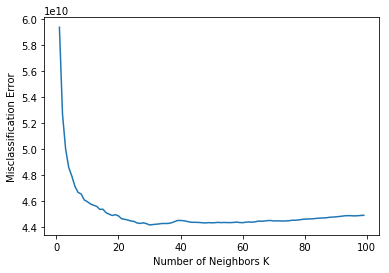

In [26]:
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print ("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

In [27]:
#Un ejemplo de knn
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=30, metric='euclidean')
knn.fit(X, y)

test_float['price_aprox_usd_KNN_30'] = knn.predict(test_float.loc[:, ['surface_total_in_m2', 'surface_covered_in_m2',\
                                        'rooms', 'PCA1', 'PCA2']])
test_float.head()

,id,created_on,property_type,operation,place_name,place_with_parent_names,country_name,state_name,lat-lon,lat,...,surface_covered_in_m2,floor,rooms,expenses,description,PCA1,PCA2,price_aprox_usd_LR,price_aprox_usd_KNN5,price_aprox_usd_KNN_30
0,3632,2017-08-24,departamento,venta,Puerto Madero,|Argentina|Capital Federal|Puerto Madero|,Argentina,Capital Federal,"-34.6109877599,-58.3634635778",-34.610988,...,359.471588,NaN,2.0,NaN,Edificio BA Houses situado frente al Dique 3 d...,-0.980251,295.601065,917132.216133,137580.0,148663.333333
1,3633,2017-08-25,departamento,venta,Buenos Aires Interior,|Argentina|Buenos Aires Interior|,Argentina,Buenos Aires Interior,NaN,-34.629923,...,359.471588,NaN,2.0,NaN,El departamento cuenta con un living-comedor a...,-0.980236,295.601107,915094.903572,137580.0,148663.333333
2,2263404,2017-08-01,departamento,venta,Palermo Soho,|Argentina|Capital Federal|Palermo|Palermo Soho|,Argentina,Capital Federal,"-34.5893633232,-58.4128798588",-34.589363,...,48.000000,NaN,2.0,1500,IMPECABLE TORRE COY III – DEPA...,-84.802212,-8.999283,128890.894117,151549.8,130221.866667
3,2263405,2017-08-01,departamento,venta,Chacarita,|Argentina|Capital Federal|Chacarita|,Argentina,Capital Federal,NaN,-34.629923,...,39.000000,NaN,2.0,NaN,AMBIENTE DIVISIBLE CON PISOS D...,-101.295409,-11.226231,108304.661839,77000.0,83350.000000
4,2263406,2017-08-01,departamento,venta,Chacarita,|Argentina|Capital Federal|Chacarita|,Argentina,Capital Federal,NaN,-34.629923,...,51.000000,NaN,2.0,NaN,LIVING COMEDOR CON PISOS DE PO...,-85.344311,-5.435046,135190.137308,119800.0,120691.196333


In [28]:
test_float_reduced = test_float.loc[:,['id', 'price_aprox_usd_KNN_30']]
test_float_reduced.head(10)

,id,price_aprox_usd_KNN_30
0,3632,148663.333333
1,3633,148663.333333
2,2263404,130221.866667
3,2263405,83350.000000
4,2263406,120691.196333
5,2263407,83350.000000
6,2263408,83350.000000
7,2263409,83350.000000
8,2263410,119246.666667
9,2263411,107761.666667


In [29]:
test_float_reduced.columns=['id', 'price_usd']
test_float_reduced.head()

,id,price_usd
0,3632,148663.333333
1,3633,148663.333333
2,2263404,130221.866667
3,2263405,83350.000000
4,2263406,120691.196333


In [30]:
test_float_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14166 entries, 0 to 14165
Data columns (total 2 columns):
id           14166 non-null int64
price_usd    14166 non-null float64
dtypes: float64(1), int64(1)
memory usage: 221.4 KB


In [40]:
test_float_reduced.to_csv('Submitk30.csv', index=False)

<br><B><FONT FACE="Arial" SIZE="5">KNN2 - en base a las propiedades: 'price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2', 'floor', 'rooms', 'lat', 'lon'</FONT></B><br/>

In [32]:
#Knn con cross-validation

feature_cols2 = ['surface_total_in_m2', 'surface_covered_in_m2', 'rooms', 'lat', 'lon', 'PCA1', 'PCA2']
X2 = data_float[feature_cols2]


from sklearn.model_selection import cross_val_score
# creating odd list of K for KNN
neighbors = list(range(1,100))


# subsetting just the odd ones
#neighbors = filter(lambda x: x % 2 != 0, myList)

# empty list that will hold cv scores
cv_scores2 = []

# perform 10-fold cross validation
for k in neighbors:
    knn2 = KNeighborsRegressor(n_neighbors=k, metric='euclidean')
    scores = cross_val_score(knn2, X2, y, cv=10, scoring='neg_mean_squared_error')
    cv_scores2.append(scores.mean())


The optimal number of neighbors is 27


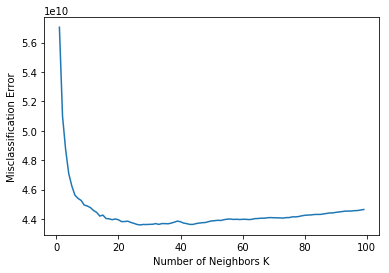

In [33]:

MSE2 = [1 - x for x in cv_scores2]

# determining best k
optimal_k2 = neighbors[MSE2.index(min(MSE2))]
print ("The optimal number of neighbors is %d" % optimal_k2)

# plot misclassification error vs k
plt.plot(neighbors, MSE2)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

In [34]:
#Un ejemplo de knn
from sklearn.neighbors import KNeighborsRegressor
knn2 = KNeighborsRegressor(n_neighbors=27, metric='euclidean')
knn2.fit(X2, y)

test_float['price_aprox_usd_KNN_27_lat_lon'] = knn2.predict(test_float.loc[:, ['surface_total_in_m2', \
                                'surface_covered_in_m2', 'rooms', 'lat', 'lon', 'PCA1', 'PCA2']])
test_float.head()

,id,created_on,property_type,operation,place_name,place_with_parent_names,country_name,state_name,lat-lon,lat,...,floor,rooms,expenses,description,PCA1,PCA2,price_aprox_usd_LR,price_aprox_usd_KNN5,price_aprox_usd_KNN_30,price_aprox_usd_KNN_27_lat_lon
0,3632,2017-08-24,departamento,venta,Puerto Madero,|Argentina|Capital Federal|Puerto Madero|,Argentina,Capital Federal,"-34.6109877599,-58.3634635778",-34.610988,...,NaN,2.0,NaN,Edificio BA Houses situado frente al Dique 3 d...,-0.980251,295.601065,917132.216133,137580.0,148663.333333,140922.222222
1,3633,2017-08-25,departamento,venta,Buenos Aires Interior,|Argentina|Buenos Aires Interior|,Argentina,Buenos Aires Interior,NaN,-34.629923,...,NaN,2.0,NaN,El departamento cuenta con un living-comedor a...,-0.980236,295.601107,915094.903572,137580.0,148663.333333,140922.222222
2,2263404,2017-08-01,departamento,venta,Palermo Soho,|Argentina|Capital Federal|Palermo|Palermo Soho|,Argentina,Capital Federal,"-34.5893633232,-58.4128798588",-34.589363,...,NaN,2.0,1500,IMPECABLE TORRE COY III – DEPA...,-84.802212,-8.999283,128890.894117,151549.8,130221.866667,131619.481481
3,2263405,2017-08-01,departamento,venta,Chacarita,|Argentina|Capital Federal|Chacarita|,Argentina,Capital Federal,NaN,-34.629923,...,NaN,2.0,NaN,AMBIENTE DIVISIBLE CON PISOS D...,-101.295409,-11.226231,108304.661839,77000.0,83350.000000,88192.592593
4,2263406,2017-08-01,departamento,venta,Chacarita,|Argentina|Capital Federal|Chacarita|,Argentina,Capital Federal,NaN,-34.629923,...,NaN,2.0,NaN,LIVING COMEDOR CON PISOS DE PO...,-85.344311,-5.435046,135190.137308,119800.0,120691.196333,129070.000000


In [35]:
test_float_reduced = test_float.loc[:,['id', 'price_aprox_usd_KNN_27_lat_lon']]
test_float_reduced.head(10)

,id,price_aprox_usd_KNN_27_lat_lon
0,3632,140922.222222
1,3633,140922.222222
2,2263404,131619.481481
3,2263405,88192.592593
4,2263406,129070.000000
5,2263407,88192.592593
6,2263408,88192.592593
7,2263409,88192.592593
8,2263410,129770.370370
9,2263411,105290.740741


In [36]:
test_float_reduced.columns=['id', 'price_usd']
test_float_reduced.head()

,id,price_usd
0,3632,140922.222222
1,3633,140922.222222
2,2263404,131619.481481
3,2263405,88192.592593
4,2263406,129070.000000


In [37]:
test_float_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14166 entries, 0 to 14165
Data columns (total 2 columns):
id           14166 non-null int64
price_usd    14166 non-null float64
dtypes: float64(1), int64(1)
memory usage: 221.4 KB


In [38]:
test_float_reduced.to_csv('SubmitK27latlon.csv', index=False)